In [6]:
# Import required packages
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] ="false"
import jax
import numpy as np
import jax.numpy as jnp
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from matplotlib.ticker import MaxNLocator


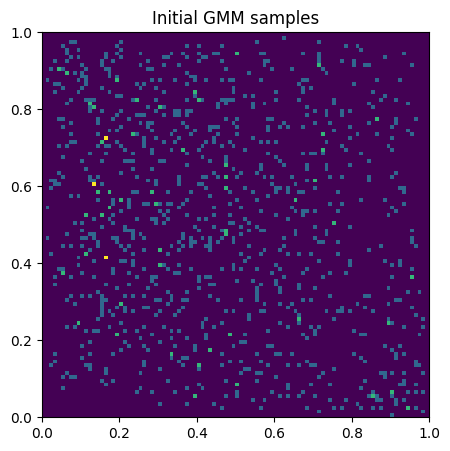

In [7]:

import bijx
import jax.random as jr
import jax.numpy as jnp
from flax import nnx
import optax
from learning.module.gmmvi.network import create_gmm_network_and_state
from learning.module.gmmvi.network import GMMTrainingState
from learning.module.target_examples.gmm40 import GMM40
from learning.module.target_examples.student_t_mixture import StudentTMixtureModel
# target = StudentTMixtureModel(dim=2, sample_bounds=[-30., 30.], num_components=40)
target = GMM40(dim=2)
# low = jnp.array([-target._plot_bound, -target._plot_bound])
# high = jnp.array([target._plot_bound, target._plot_bound])
low = jnp.array([-0.0, 0.0])
high = jnp.array([1., 1.0])
ndim=2
num_envs= 1024
batch_size= 1024
key = jax.random.PRNGKey(0)
key, key_sample = jax.random.split(key)
initial_train_state, gmm_network = create_gmm_network_and_state(
    ndim, num_envs, batch_size, key, prior_scale=.5, bound_info=(low, high))


# Sampling:
contexts, logp = gmm_network.model.sample(initial_train_state.model_state.gmm_state, key, 1000)
plt.figure(figsize=(5, 5))
plt.hist2d(contexts[:, 0], contexts[:, 1], bins=100, range=[[low[0], high[0]], [low[1], high[1]]])
plt.title("Initial GMM samples")
plt.show()


In [8]:
#gmm training function
import chex
from typing import Tuple
import functools 
@functools.partial(jax.jit, static_argnames=['target_log_prob_fn'])
def train_iter(train_state: GMMTrainingState, key: chex.Array, target_log_prob_fn):
    key, subkey = jax.random.split(key)
    new_samples, mapping = gmm_network.sample_selector.select_samples(train_state.model_state,
                                        subkey)
    # new_samples, mapping = gmm_network.model.sample(train_state.model_state.gmm_state, subkey, batch_size)
    new_target_lnpdfs = target_log_prob_fn(new_samples)
    new_target_grads = jnp.zeros_like(new_samples)
    new_sample_db_state = gmm_network.sample_selector.save_samples(train_state.model_state, \
            train_state.sample_db_state, new_samples, new_target_lnpdfs, new_target_grads, mapping)
    samples, mapping, sample_dist_densities, target_lnpdfs, target_lnpdf_grads = \
        gmm_network.sample_selector.select_train_datas(new_sample_db_state)

    new_component_stepsizes = gmm_network.component_stepsize_fn(train_state.model_state)
    new_model_state = gmm_network.model.update_stepsizes(train_state.model_state, new_component_stepsizes)
    expected_hessian_neg, expected_grad_neg = gmm_network.more_ng_estimator(new_model_state,
                                                            samples,
                                                            sample_dist_densities,
                                                            target_lnpdfs,
                                                            target_lnpdf_grads)
    new_model_state = gmm_network.component_updater(new_model_state,
                                    expected_hessian_neg,
                                    expected_grad_neg,
                                    new_model_state.stepsizes)

    new_model_state = gmm_network.weight_updater(new_model_state, samples, sample_dist_densities, target_lnpdfs,
                                                    train_state.weight_stepsize)
    new_num_updates = train_state.num_updates + 1
    key, subkey = jax.random.split(key)
    new_model_state, new_component_adapter_state, new_sample_db_state = \
        gmm_network.component_adapter(train_state.component_adaptation_state,
                                                    new_sample_db_state,
                                                    new_model_state,
                                                    new_num_updates,
                                                    subkey)
    return GMMTrainingState(temperature=train_state.temperature,
                        model_state=new_model_state,
                        component_adaptation_state=new_component_adapter_state,
                        num_updates=new_num_updates,
                        sample_db_state=new_sample_db_state,
                        weight_stepsize=train_state.weight_stepsize)


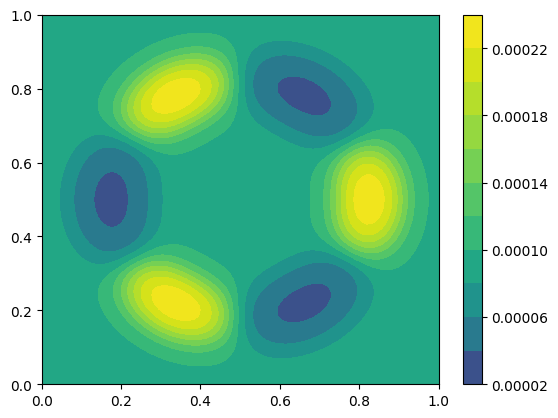

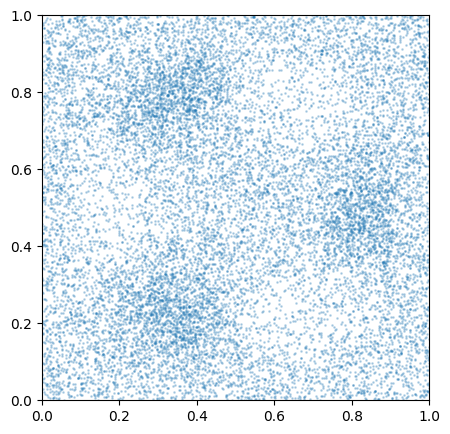

In [9]:
import jax, jax.numpy as jnp
from matplotlib.colors import PowerNorm
import numpy as np
import matplotlib.pyplot as plt
import imageio
import optax
import functools

from learning.module.bijx.utils import render_flow_pdf_2d_subplots
beta = -1
gamma = 0.45
def target1(x):
    # Mixture of two Gaussians
    mean1 = jnp.array([1.0, 0.4])
    cov1 = 0.3 * jnp.array([[1.0, 0.3], [0.3, 1.0]])

    mean2 = jnp.array([-1.0, -0.4])
    cov2 = 0.1 * jnp.array([[1.0, -0.3], [-0.3, 1.0]])

    pdf1 = jax.scipy.stats.multivariate_normal.pdf(x, mean1, cov1)
    pdf2 = jax.scipy.stats.multivariate_normal.pdf(x, mean2, cov2)

    return jnp.log(0.4 * pdf1 + 0.6 * pdf2).squeeze()

def target2(z):
    """
    Returns log \tilde{p}(z) = -beta * u(z), where u is your energy.
    This is *unnormalized* (no logZ). Stable for all real beta.
    """
    z1, z2 = jnp.split(z, 2, axis=-1)          # each (..., 1)

    # stable radius
    r = jnp.hypot(z1, z2)                      # (..., 1)

    # compute log(exp1 + exp2) stably
    logexp1 = -0.5 * jnp.square((z1 - 2.0) / 0.8)  # (..., 1)
    logexp2 = -0.5 * jnp.square((z1 + 2.0) / 0.8)  # (..., 1)

    # stack along a new last axis of size 2, then logsumexp over that axis
    log_mix = jax.nn.logsumexp(jnp.concatenate([logexp1, logexp2], axis=-1),
                        axis=-1, keepdims=True)    # (..., 1)

    u = 0.5 * jnp.square((r - 4.0) / 0.4) - log_mix  # (..., 1)

    logp = beta*u
    return jnp.squeeze(logp, axis=-1)  # (...,)

def target3(z):
    m=3
    r0=0.65
    sr=0.12
    X, Y = jnp.split(z, 2, axis=-1)
    x = 2.0 * (X - 0.5)
    y = 2.0 * (Y - 0.5)
    r = jnp.hypot(x, y)
    theta = jnp.arctan2(y, x)

    ring = jnp.exp(-0.5 * ((r - r0) / sr) ** 2)
    petals = jnp.cos(m * theta)
    U = jnp.tanh(1.6 * (ring * petals))  # bounded in (-1, 1)
    log_unnorm = -beta * U.squeeze()
    return jax.nn.log_softmax(log_unnorm)

def reward_corner(contexts, target=jnp.array([0.3, 0.7]), sigma=0.12, noise_std=0.2, key=None):
    # reward in [0,1], peaked near target
    diff = contexts - target[None, :]
    r = jnp.exp(-0.5 * jnp.sum((diff / sigma) ** 2, axis=-1))
    if key is not None:
        r = jnp.clip(r + noise_std * jax.random.normal(key, r.shape), 0.0, 1.0)
    return r.squeeze()

volume = jnp.prod(high - low)
N = 2 **10
def run_toy_corner(current_state):
    x, y = jnp.meshgrid(jnp.linspace(low[0], high[0], 100), jnp.linspace(low[1], high[1], 100))
    grid = jnp.c_[x.ravel(), y.ravel()]
    # pdf_values = reward_corner(grid)
    # pdf_values = target1(grid)
    # pdf_values =  target2(grid)
    pdf_values =  target3(grid)
    # pdf_values = target.log_prob(grid)
    pdf_values = jnp.exp(pdf_values)
    pdf_values = jnp.reshape(pdf_values, x.shape)
    T = 1000
    snap_iters = [0, 1, 2, 5, 10, 15, 24] + list(range(30, T, 10))
    snap_iters = []
    key = jax.random.PRNGKey(0)
    gif_frames = [] 
    
    for t in range(T):
        kplot, ktrain, key = jax.random.split(key, 3)
        current_state = train_iter(current_state, ktrain, target3)  #target.log_prob)
        if t in snap_iters:
            fig, (ax_reward, ax_NF) = plt.subplots(1, 2, figsize=(10, 4))
            ctf = ax_reward.contourf(x, y, pdf_values, levels=10, cmap="viridis",  linewidths=0.6, norm=PowerNorm(gamma))
            ax_reward.set_title("reward_corner landscape")
            ax_reward.set_xlabel("context dim 1")
            ax_reward.set_ylabel("context dim 2")
            fig.colorbar(ctf, ax=ax_reward, label="reward")
            z, _ = gmm_network.model.sample(current_state.model_state.gmm_state, kplot, 2**8)
            ax_NF = render_flow_pdf_2d_subplots(
                log_prob_fn=lambda x : jax.vmap(functools.partial(gmm_network.model.log_density,\
                gmm_state=current_state.model_state.gmm_state))(sample=x),
                low=low,
                high=high,
                ax=ax_NF,
                samples=z,
            )
            ax_NF.set_title(f"GMM training distribution (iter {t}) [beta = {beta}]")
            fig.tight_layout()
            fig.canvas.draw()
            frame = np.asarray(fig.canvas.buffer_rgba())[..., :3]
            gif_frames.append(frame)
            plt.close(fig)

    if gif_frames:
        imageio.mimsave(f"GMM training [beta= {beta}].gif", gif_frames, fps=4)
        print("Saved GIF")
    key = jax.random.PRNGKey(0)
    x, _ = gmm_network.model.sample(current_state.model_state.gmm_state, key, 2**14)
    x_np = np.array(x)
    np.save(f"gmm_samples_beta={beta}.npy", x_np)
    # 1) Raw scatter plot (no binning)
    plt.figure(figsize=(5, 5))
    plt.scatter(x[:, 0], x[:, 1], s=1, alpha=0.25)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    # plt.title("Scatter of gmm samples (iter 0)")
    plt.savefig(f"gmm_sample_image_beta={beta}.png")
    plt.show()
    # # 2) Coarse 2D histogram to kill striping
    # plt.figure(figsize=(5, 5))
    # plt.hist2d(x[:, 0], x[:, 1], bins=40, range=[[low[0], high[0]], [low[1], high[1]]])
    # plt.title("gmm samples hist2d, coarse bins")
    # plt.show()

x, y = jnp.meshgrid(jnp.linspace(low[0], high[0], 100), jnp.linspace(low[1], high[1], 100))
grid = jnp.c_[x.ravel(), y.ravel()]
# pdf_values = reward_corner(grid)
# pdf_values = target1(grid)
pdf_values = target3(grid)
# pdf_values = target.log_prob(grid)
pdf_values = jnp.exp(pdf_values)
pdf_values = jnp.reshape(pdf_values, x.shape)
fig = plt.figure()
ctf = plt.contourf(x, y, pdf_values, levels=10, cmap="viridis", norm=PowerNorm(gamma))
cbar = fig.colorbar(ctf)
# ax = render_flow_pdf_2d_subplots(
#     log_prob_fn=lambda x : jax.vmap(functools.partial(gmm_network.model.log_density,\
#         gmm_state=initial_train_state.model_state.gmm_state))(sample=x),
#     low=low,
#     high=high,
# )
run_toy_corner(initial_train_state)


FileNotFoundError: [Errno 2] No such file or directory: 'gmm_samples_beta=-10.npy'

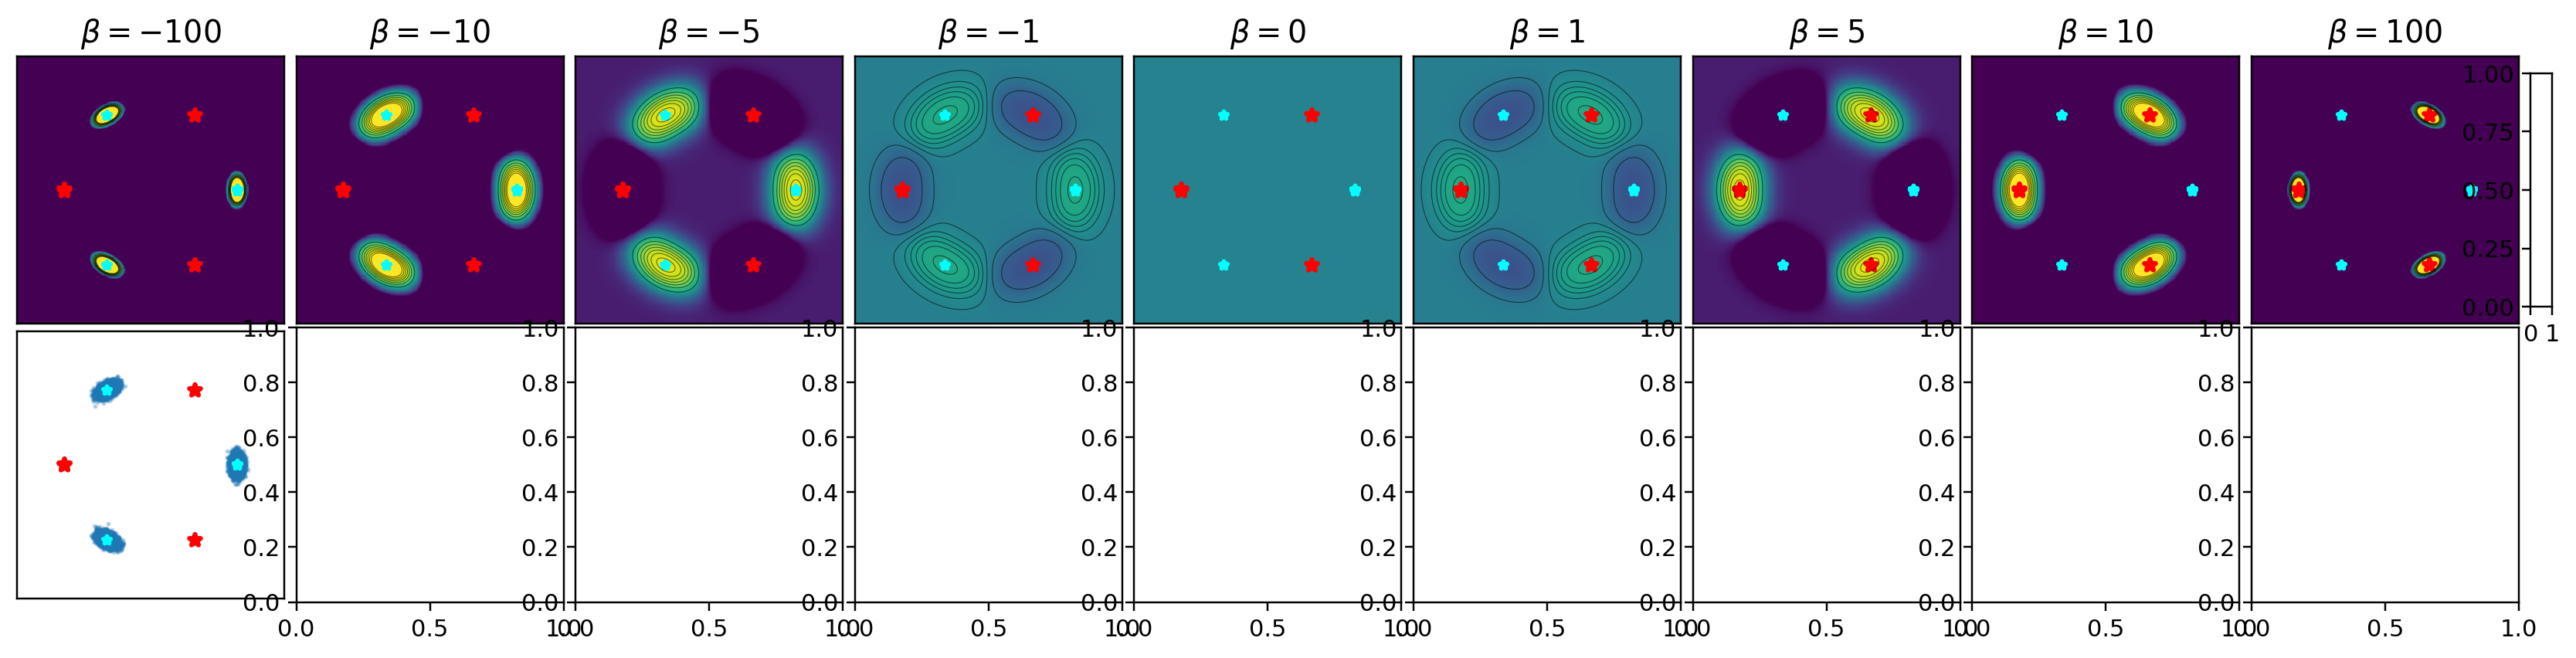

: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm, SymLogNorm
from matplotlib.colors import LogNorm, PowerNorm
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.ndimage import maximum_filter, minimum_filter # Needed for peak detection
# plt.rcParams.update({
#     "font.family": "sans-serif",
#     # This forces Matplotlib to use the internal Computer Modern fonts
#     "mathtext.fontset": "cm", 
#     # "font.sans-serif": ["Computer Modern Sans Serif"], 
# })
def U_flower_ring_unit(X, Y, m=3, r0=0.65, sr=0.12, alpha=1.6):
    x = 2.0 * (X - 0.5)
    y = 2.0 * (Y - 0.5)
    r = np.hypot(x, y)
    theta = np.arctan2(y, x)
    ring = np.exp(-0.5 * ((r - r0) / sr) ** 2)
    petals = np.cos(m * theta)
    return -np.tanh(alpha * (ring * petals))

def logsumexp_np(a):
    m = np.max(a)
    return m + np.log(np.sum(np.exp(a - m)))

def normalized_pdf_on_grid(U, beta, dx, dy):
    log_unnorm = beta * U
    logZ = logsumexp_np(log_unnorm) + np.log(dx * dy)
    return np.exp(log_unnorm - logZ)

# Grid
n = 320
xs = np.linspace(0.0, 1.0, n)
ys = np.linspace(0.0, 1.0, n)
X, Y = np.meshgrid(xs, ys, indexing="xy")
dx = (xs[-1] - xs[0]) / (n - 1)
dy = (ys[-1] - ys[0]) / (n - 1)

U = U_flower_ring_unit(X, Y)
local_max_mask = (maximum_filter(U, size=20) == U)[1:-1]
local_min_mask = (minimum_filter(U, size=20) == U)[1:-1]
max_x, max_y = X[1:-1][local_max_mask], Y[1:-1][local_max_mask]
min_x, min_y = X[1:-1][local_min_mask], Y[1:-1][local_min_mask]
betas = np.array([-100.0, -10.0, -5.0, -1.0, 0.0, 1.0, 5.0, 10.0, 100.0])
pdfs = [normalized_pdf_on_grid(U, b, dx, dy) for b in betas]

all_vals = np.concatenate([p.ravel() for p in pdfs])
vmax = np.percentile(all_vals, 99.3)
vmin = 0.1
gamma = 0.45
norm = PowerNorm(gamma=gamma, vmin=vmin, vmax=vmax)
norm = LogNorm(vmin=vmin, vmax=vmax)
norm = SymLogNorm(vmin=vmin, vmax=vmax, linthresh=0.015)

cmap = cm.viridis.copy()
cmap.set_under("black")
cmap.set_over("white")

fig = plt.figure(figsize=(2.05*len(betas) + 0.8, 4.2), dpi=220)
gs = fig.add_gridspec(2, len(betas) + 1, width_ratios=[1]*len(betas) + [0.08], wspace=0.05, hspace=0.00)

axes_row1 = [fig.add_subplot(gs[0, i]) for i in range(len(betas))]
axes_row2 = [fig.add_subplot(gs[1, i]) for i in range(len(betas))]
container = fig.add_subplot(gs[0, len(betas)])
container.set_axis_off()  # Hide the container's borders/ticks
cax = inset_axes(container, width="100%", height="85%", loc='center')

for ax, b, p in zip(axes_row1, betas, pdfs):
    p_vis = np.clip(p, vmin, vmax)
    im = ax.imshow(
        p_vis, origin="lower", extent=(0, 1, 0, 1), aspect="equal",
        cmap=cmap, norm=norm, interpolation="nearest",
    )
    ax.contour(X, Y, p_vis, levels=8, linewidths=0.35, colors="k", alpha=0.55, antialiased=True, )
    h_max = ax.scatter(max_x, max_y, s=25, c='red', marker='*', edgecolors='red', linewidth=2., label='Maximizer of E(x)')
    h_min = ax.scatter(min_x, min_y, s=10, c='cyan', marker='*', edgecolors='cyan', linewidth=2.,label="Minimizer of E(x)")
    ax.set_title(f"$\\beta={b:g}$", fontsize=13, y=1)
    ax.set_xticks([])
    ax.set_yticks([])
for ax, b, p in zip(axes_row2, betas, pdfs):
    x_loaded = np.load(f'gmm_samples_beta={int(b)}.npy')
    ax.scatter(x_loaded[:, 0], x_loaded[:, 1], s=1, alpha=0.25)
    h_max = ax.scatter(max_x, max_y, s=25, c='red', marker='*', edgecolors='red', linewidth=2., label='Maximizer of E(x)')
    h_min = ax.scatter(min_x, min_y, s=10, c='cyan', marker='*', edgecolors='cyan', linewidth=2.,label="Minimizer of E(x)")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])

cb = fig.colorbar(im, cax=cax)#, extend="both")
# cb.set_label(f"pβ(z) (PowerNorm γ={gamma}, vmax@99.3% clip)", fontsize=9)
fig.legend(handles=[h_max, h_min], loc='upper center', 
           bbox_to_anchor=(.22, .13), ncol=2, frameon=False, fontsize=11)
fig.suptitle(r"Boltzmann Distribution [$p(x) \propto \exp(\beta E(x))$] with varying $\beta$", y=1.02, fontsize=20)
plt.show()

print(f"Visualization: cmap=turbo (under=black, over=white), PowerNorm gamma={gamma}, vmax≈{vmax:.3e} (global 99.3%)")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

# --- 1. Setup Natural Sans-Serif Fonts ---
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "Arial", "DejaVu Sans"],
    "mathtext.fontset": "stixsans",
    "font.size": 12,
    "axes.linewidth": 1.5,
    "xtick.major.width": 1.5,
    "ytick.major.width": 1.5,
})

# --- 2. Define the "Many Well" Energy Function ---
def rugged_energy_1d(x, k_bowl=.1, A_wiggle=5.5, freq_wiggle=1.0):
    """
    Combines a quadratic bowl with a cosine wiggle.
    E(x) = 0.5 * k * x^2 - A * cos(freq * x)
    """
    bowl = 0.5 * k_bowl * x**2
    wiggle = -A_wiggle * np.cos(freq_wiggle * x)
    return bowl + wiggle

# --- 3. Define Gibbs Distribution Calculation ---
def compute_gibbs_pdf(E_vals, beta, dx):
    """Computes p(x) = exp(E(x)) / Z"""
    # 1. Compute unnormalized probabilities (Boltzmann factor)
    # Subtract min(E) for numerical stability to avoid overflow/underflow
    unnormalized_p = np.exp(beta*(E_vals - np.min(E_vals)))
    
    # 2. Compute Partition Function Z (integral approx using trapezoidal rule)
    Z = np.trapz(unnormalized_p, dx=dx)
    
    # 3. Normalize
    return unnormalized_p / Z

# --- 4. Generate Data ---
# Create grid
x_min, x_max = -6.5, 6.5
n_points = 2000 # High resolution for smooth peaks
x = np.linspace(x_min, x_max, n_points)
dx = x[1] - x[0]

# Compute Energy and Probability
E_vals = rugged_energy_1d(x)
# 2. Plot Distributions (Primary Axis)


# --- 5. Find Energy Minima (Wells) for highlighting ---
# Find indices where E(x) is a local minimum
minima_indices = argrelextrema(E_vals, np.less)[0]
x_minima = x[minima_indices]
E_minima = E_vals[minima_indices]


# --- 6. Visualization ---
# Create 2 subplots sharing the X axis
plt.close()
fig, (ax_energy, ax_prob) = plt.subplots(2, 1, figsize=(5, 8), sharex=True, dpi=150)

# --- Top Plot: Energy E(x) ---
ax_energy.plot(x, E_vals, color='#D95319', linewidth=2.5, label='$E(x)$')
# Mark the wells
# ax_energy.scatter(x_minima, E_minima, color='black', s=60, zorder=5, label='Energy Wells (Minima)')

ax_energy.set_ylabel("Expected Return $J_{\pi}$", fontsize=14, fontweight='bold')
ax_energy.set_title("Return Landscape", fontsize=16, pad=15)
# ax_energy.grid(True, linestyle='--', alpha=0.6)
ax_energy.set_xlabel("latent dynamics parameter $\\xi$ ")
# ax_energy.legend(loc='upper center', frameon=False)

# --- Bottom Plot: Gibbs Distribution p(x) ---
# Use fill_between for a nice probability density look
colors = ['#D32F2F', '#FF7043', '#757575', '#42A5F5', '#1976D2']
betas = [-5., -1, 0, 1 , 5.0]
for beta, color in zip(betas, colors):
    p = compute_gibbs_pdf(E_vals, beta, dx)
    ax_prob.plot(x, p, linewidth=2.5, color=color, label=f'$\\beta = {beta}$')
# ax_prob.fill_between(x, p, color='#0072BD', alpha=0.4)
# ax_prob.plot(x, p_vals, color='#0072BD', linewidth=2.5, label='$p(x) \propto \exp(-E(x))$')

ax_prob.set_ylabel("Boltzmann Distribution $\\nu_\\beta(x)$", fontsize=12)
ax_prob.set_xlabel("latent dynamics parameter $\\xi$", fontsize=14)
ax_prob.set_title("The resulting Gibbs Distribution", fontsize=16, pad=15)
ax_prob.grid(True, linestyle='--', alpha=0.6)
ax_prob.legend(loc='upper right', frameon=False)
ax_prob.set_ylim(bottom=0) # Probability cannot be negative

# --- Connecting Lines ---
# Draw vertical dashed lines connecting the energy wells to probability peaks
# for x_pos in x_minima:
#     # Draw line across both axes
#     fig.add_artist(plt.Line2D([x_pos, x_pos], [0.05, 0.93], transform=fig.transFigure, 
#                               color='gray', linestyle=':', linewidth=1.5, alpha=0.5, zorder=-1))

plt.tight_layout()
# Adjust layout to make room for the connecting lines drawn in figure coords
# plt.subplots_adjust(hspace=0.3) 
plt.show()
